# Reservoirs computing for simulated longitudinal data

## Objective

Study the capacity of Reservoir Computing (RC) to model longitudinal health data with mixed effects.  

In other word: do the modelisation of complex time dependecies can compensate the lack of direct modelisation of the random effect?

## Method
### Sub-studies


4 sub-studies have been done:
- SF x FE
- SF x ME
- AF x FE
- AF x ME

With:  
- SF = "Simple Features" $\Rightarrow x_2 * x_5$, $x_4 * x_7$, $x_6 * x_8$  
- AF = "All Features" $\Rightarrow x_1,…,x_8$  

And:  
- FE = "Fixed Effect (with noise)" $\Rightarrow y_{fixed,obs}$
- ME = "Mixed Effect (with noise)" $\Rightarrow y_{mixed,obs}$  

### Steps

Hyper-parameters (HP) optimization:
1. Using *simulation_1* for training and *simulation_2* for validation
2. Using *simulation_2* for training and *simulation_1* for validation
3. Getting the best HPs sets.
4. Computing the best HPs as the median on the sets.

Training:
1. Loading the optimized HP
2. Training on each *simulation_i* and testing on *test_01*
3. Computing the mean MSE and MAE on all the simulations

`N_warmups = 5`: the 5 first timesteps that are ignored in the computation of the losses and errors.

### Hyper-parameters optimization

From *Unsupervised Reservoir Computing for Solving Ordinary Differential Equations [Mattheakis 2021]*:  
> Training an RC is efficient, however, finding the optimal hyper-parameters that determine the weight distributions and the network architecture is challenging. **RC performance strongly depends on these hyper-parameters** and, therefore, finding good hyper-parameters is crucial. The RC has many hyper-parameters making this a **computationally expensive process**.


We will use [Optuna](https://optuna.org/) for the hyper-parameters optimization, with the TPE (Tree-structured Parzen Estimator) algorithm.

#### Notes on Optuna's TPESampler  

https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html  
> Sampler using TPE (Tree-structured Parzen Estimator) algorithm.  
On each trial, for each parameter, TPE fits one Gaussian Mixture Model (GMM) $l(x)$ to the set of parameter values associated with the best objective values, and another GMM $g(x$) to the remaining parameter values. It chooses the parameter value x that maximizes the ratio $l(x)/g(x)$.

https://anna-ssi.github.io/blog/tpe/  
> Tree-structured Parzen Estimators (TPE) derive their name from the **combination of Parzen estimators to model the probability distributions of hyperparameters and a structured, graph-like approach to represent hyperparameter configurations**. In this tree-like representation, each hyperparameter is a node, and edges denote the dependencies between them.  
For example, the choice of the optimizer (e.g., Adam) and the learning rate can be seen as interconnected nodes.  
This structured representation allows TPE to focus on updating only the relevant parts of the model when new observations are made.  
It also facilitates establishing **dependencies among random variables**, making conditional sampling more efficient and enabling the algorithm to optimize the search space faster.

#### HP optimization details


**trial**: set of hyperparameters suggested by Optuna   

```
for each trial:
    for 5 random seeds:
        generate a reservoir model
        train the reservoir on X_train_scaled and Y_train_scaled
        predict on X_val_scaled
        compute the MSE between Y_val_scaled and Y_pred_scaled: MSE_seed 
    compute MSE_trial = mean(MSE_seed)
return MSE_trial and N_units

Use a Pareto front for best MSE/N_units compromises
```

### Training details

```
for 5 random seeds:
    generate a reservoir model with the best HP
    train the reservoir on X_train_scaled and Y_train_scaled
    predict on X_test_scaled
    unscale Y_pred_scaled
    compute the MSE between Y_test and Y_pred: MSE_seed
    (same with MAE)
compute MSE = mean(MSE_seed)
(same with MAE) 
```

In [1]:
from warnings import filterwarnings
from json import dump
from math import log10, floor

import matplotlib.pyplot as plt
from optuna import load_study
from optuna.exceptions import ExperimentalWarning

# from optuna.visualization import plot_pareto_front
from optuna.visualization.matplotlib import plot_pareto_front, plot_slice
from pandas import DataFrame, set_option

filterwarnings("ignore", category=ExperimentalWarning)

## HP optimization for SF x FE

In [2]:
def get_study(study_name):
    db_name = f"{study_name}.db"
    storage_name = f"sqlite:///{db_name}"
    study = load_study(study_name=study_name, storage=storage_name)
    print(study.study_name, "loaded.")
    return study

In [3]:
study_1 = get_study("HP-optimization-01")
study_2 = get_study("HP-optimization-02")

HP-optimization-01 loaded.
HP-optimization-02 loaded.


In [4]:
min_mse = min([bt.values[0] for bt in study_1.best_trials] + [bt.values[0] for bt in study_2.best_trials])
scale= floor(log10(min_mse))
min_mse_scale = floor(min_mse/10**scale) * 10**scale

max_mse_scale = 1e1

### Influence of the HPs

(0.004, 10.0)

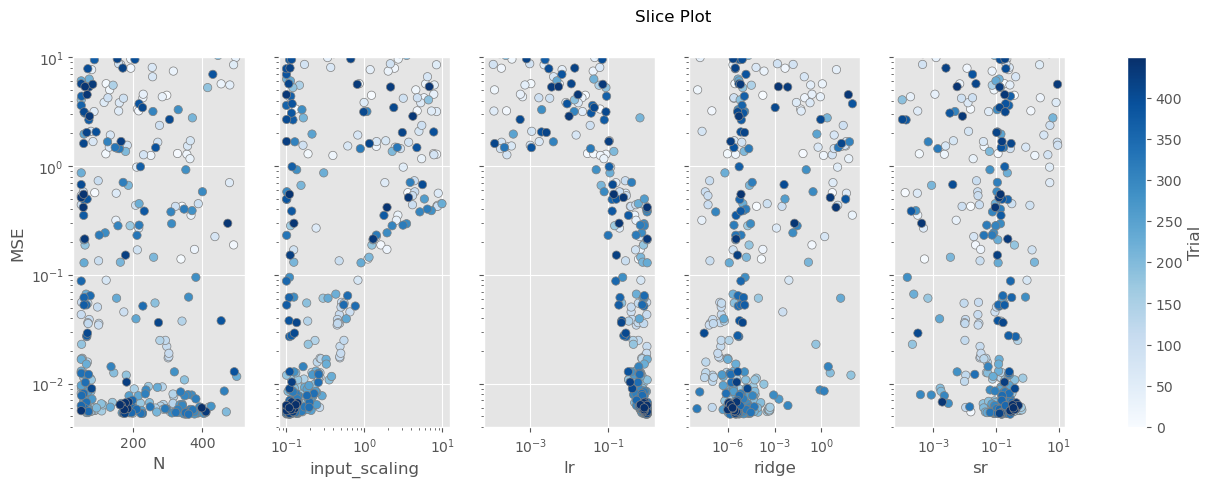

In [5]:
axes = plot_slice(
    study_1,
    params=["N", "sr", "lr", "ridge", "input_scaling"],
    target=lambda t: t.values[0],
    target_name="MSE",
)
ax = axes[0]
ax.set_yscale("log")
ax.set_ylim( bottom= min_mse_scale, top=max_mse_scale)

(0.004, 10.0)

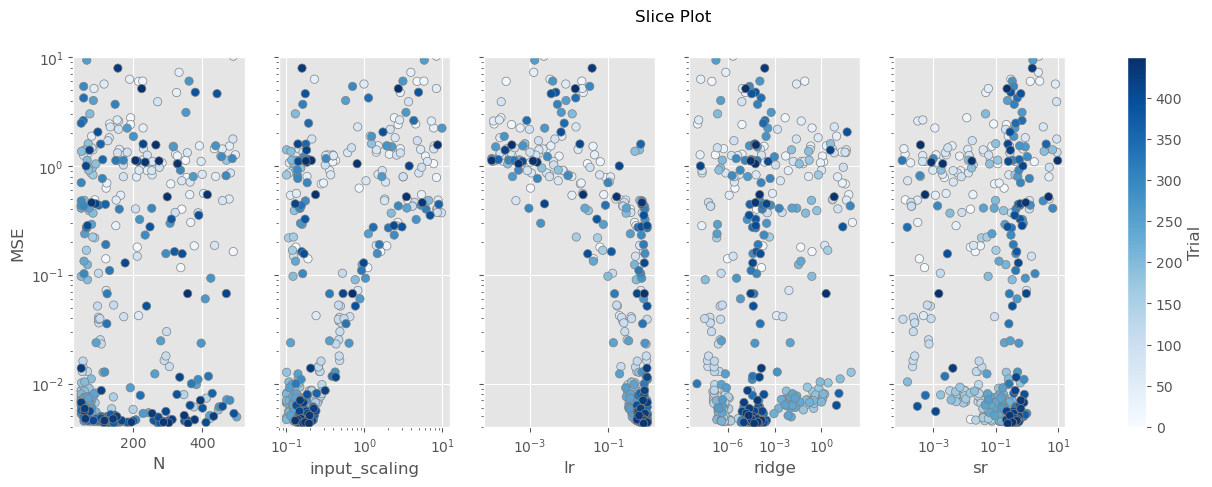

In [6]:
axes = plot_slice(
    study_2,
    params=["N", "sr", "lr", "ridge", "input_scaling"],
    target=lambda t: t.values[0],
    target_name="MSE",
)
ax = axes[0]
ax.set_yscale("log")
ax.set_ylim( bottom= min_mse_scale, top=max_mse_scale)

Strong effect of lr and input_scaling only.

Smaller effet of sr.

### Best trials (Pareto front)

Text(0.5, 1.0, 'Pareto-front for optimization #1')

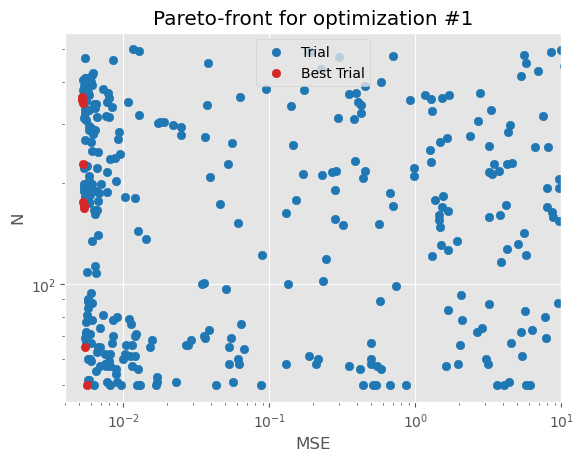

In [7]:
ax = plot_pareto_front(study_1, target_names=["MSE", "N"])

ax.set_xlim(left=min_mse_scale, right=max_mse_scale)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Pareto-front for optimization #1")

In [8]:
best_mse = min((t.values[0] for t in study_1.best_trials))

MSE_max = 1.01 * best_mse

sorted(
    (
        {"trial_num": t.number, "MSE": t.values[0], "N": t.values[1]}
        for t in study_1.best_trials
        if t.values[0] < MSE_max
    ),
    key=lambda x: x["N"],
)

[{'trial_num': 280, 'MSE': 0.005277836972697743, 'N': 346.0},
 {'trial_num': 268, 'MSE': 0.005239113385412885, 'N': 352.0},
 {'trial_num': 336, 'MSE': 0.005238662379568669, 'N': 360.0}]

In [9]:
best_params_1 = [
    study_1.trials[336].params,
    study_1.trials[268].params,
]

Text(0.5, 1.0, 'Pareto-front for optimization #2')

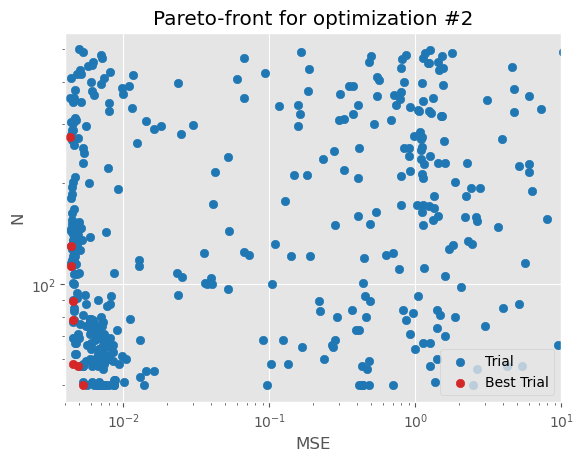

In [10]:
ax = plot_pareto_front(study_2, target_names=["MSE", "N"])

ax.set_xlim(left=min_mse_scale, right=max_mse_scale)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Pareto-front for optimization #2")

In [11]:
best_mse = min((t.values[0] for t in study_2.best_trials))

MSE_max = 1.02 * best_mse

sorted(
    (
        {"trial_num": t.number, "MSE": t.values[0], "N": t.values[1]}
        for t in study_2.best_trials
        if t.values[0] < MSE_max
    ),
    key=lambda x: x["N"],
)

[{'trial_num': 337, 'MSE': 0.0043492795664533115, 'N': 130.0},
 {'trial_num': 360, 'MSE': 0.004291710188277473, 'N': 274.0}]

In [12]:
best_params_2 = [
    study_2.trials[337].params,
    study_2.trials[360].params,
]

Comparison between the best params of both optimizations.

In [13]:
set_option('display.float_format', '{:#.2g}'.format)
df_best = DataFrame(best_params_1 + best_params_2)
df_best

,N,sr,lr,input_scaling,ridge
0,360,0.28,0.92,0.11,1.4e-06
1,352,0.15,0.99,0.11,3.2e-06
2,130,0.45,1.0,0.18,3.2e-05
3,274,0.38,0.84,0.17,6.0e-05


In [14]:
dict_params = df_best.median().to_dict()
dict_params

{'N': 313.0,
 'sr': 0.3321917150333029,
 'lr': 0.9538216748928716,
 'input_scaling': 0.13918550999524348,
 'ridge': 1.7432432511872107e-05}

In [15]:
dict_params['N'] = int(dict_params['N'])

In [16]:
with open('HP_medians.json', 'w' ) as j:
    dump(dict_params, j)